# Miniproject 1
Fingermovements predicting

**///////////// TODO //////////////**

split val_acc og train_acc i 2 figurer med samme farge

bare hvis test_error på siste result
så diskuter crossvalidation and stratified shufflegreier

- continue with LSTM
    - stacked LSTM
    - dropout
    - hidden width 
    - several hidden layers
- last phase
    - prøve "lstm_0.4drop_200e_100hrz" med 110 epochs ettersom det ser bra ut på val_loss...
    - check with different optimizers
    - loss functions
    - activation functions
- fix densemodel so it work without flattening data first...must hardcode the best densenet in the end i think
- remember to set seed and check if reprodusible
- make test.py that trains and plots the comparison of chosen algorihtms

In [1]:
# IMPORTS
import torch
from torch import Tensor, nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset
import numpy as np
from math import log10
import dlc_bci as bci
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pickle

# Our own code
import helpers as HL
import plot_func as PL
import models as ML
from models import *

%reload_ext autoreload
%autoreload 2

### Importing data

In [2]:
train_data, val_data, test_data = HL.import_data(flatten=False, one_khz=False, train_size=253)
print("train:{:0.2f}%, val{:0.2f}%, test{:0.2f}%".format((train_data.target_tensor.size()[0]/416), (val_data.target_tensor.size()[0]/416), (test_data.target_tensor.size()[0]/416)))
      

Original data format: 
<class 'torch.FloatTensor'> torch.Size([316, 28, 50])
<class 'torch.LongTensor'> torch.Size([316])
<class 'torch.FloatTensor'> torch.Size([100, 28, 50])
<class 'torch.LongTensor'> torch.Size([100])
Modified train_data.data_tensor shape:  torch.Size([253, 28, 50])
Modified train_data.target_tensor shape:  torch.Size([253, 2])
val_data.data_tensor shape:  torch.Size([63, 28, 50])
train:0.61%, val0.15%, test0.24%


### Create new models if you want

In [3]:


# class LSTM_basic_dropout
# class LSTM_2

### Choose model and define loss criterion and train

In [122]:
# initialize parameters and hyperparameters
input_dim = len(train_data[0][0])
sequence_length = train_data.data_tensor.size()[2]
output_dim = train_data.target_tensor.size(1)
nb_hidden_layers = 3
hidden_width = 111
dropout_rate=0.4

print("input_dim: ", input_dim)
print("output_dim: ", output_dim)

# initialize the models
linear_model = ML.linear_model(input_dim*sequence_length, output_dim)
logistic_model = ML.logistic_model(input_dim*sequence_length, output_dim)
#densemodel_1 = ML.DenseNet(input_dim, output_dim, nb_hidden_layers, hidden_width, dropout_rate)

ffnn_model = ML.FFNN(input_dim*sequence_length, output_dim, hidden_width, dropout_rate)
conv_model1 = ML.conv_net1(input_dim, hidden_width, output_dim)
lstm_model = ML.LSTM_net(input_dim, dim_recurrent=111, num_layers=1, dim_output=output_dim)
lstm_dropout = ML.LSTM_basic_dropout(input_dim, output_dim, recurrent_dim=hidden_width, num_layers=1, dropout_rate=dropout_rate)
lstm_2_dropout = ML.LSTM_basic_dropout(input_dim, output_dim, recurrent_dim=hidden_width, num_layers=2, dropout_rate=dropout_rate)

# choosing model
model = lstm_dropout

# define loss criterion
criterion = nn.BCELoss()
#criterion = nn.MSELoss() # for linear_model

# choose optimizer
optimizer = torch.optim.SGD # default
#optimizer = torch.optim.SGD

print(model)


input_dim:  28
output_dim:  2
LSTM_basic_dropout(
  (lstm): LSTM(28, 111, batch_first=True, dropout=0.4)
  (fc_o2y): Linear(in_features=111, out_features=2, bias=True)
)


### Training model

In [123]:
trained_model, history, parameters = HL.train_model(train_data, val_data, model, criterion, optimizer, learning_rate=3e-5, epochs=200, batch_size=32, checkpoint_name='testingtesting')


Number of trainsamples:  253
Number of valsamples:  63
===> Epoch 0 Complete: Avg. Loss: 0.0228
===> Prediction TRAIN-error: 0.5100
===> Avg. VAL-loss: 0.0227
===> Prediction  VAL-error: 0.4909
Checkpoint: checkpoint_models/testingtesting_epoch_0.pth -------------------------------------
===> Epoch 20 Complete: Avg. Loss: 1.9077
===> Prediction TRAIN-error: 0.5217
===> Avg. VAL-loss: 0.4756
===> Prediction  VAL-error: 0.5071
Checkpoint: checkpoint_models/testingtesting_epoch_20.pth -------------------------------------
===> Epoch 40 Complete: Avg. Loss: 1.8970
===> Prediction TRAIN-error: 0.5178
===> Avg. VAL-loss: 0.4751
===> Prediction  VAL-error: 0.5071
Checkpoint: checkpoint_models/testingtesting_epoch_40.pth -------------------------------------
===> Epoch 60 Complete: Avg. Loss: 1.8900
===> Prediction TRAIN-error: 0.5018
===> Avg. VAL-loss: 0.4743
===> Prediction  VAL-error: 0.5232
Checkpoint: checkpoint_models/testingtesting_epoch_60.pth -------------------------------------
===

### Plotting data from training
- here is NEW model that was just trained benchpressed with other models

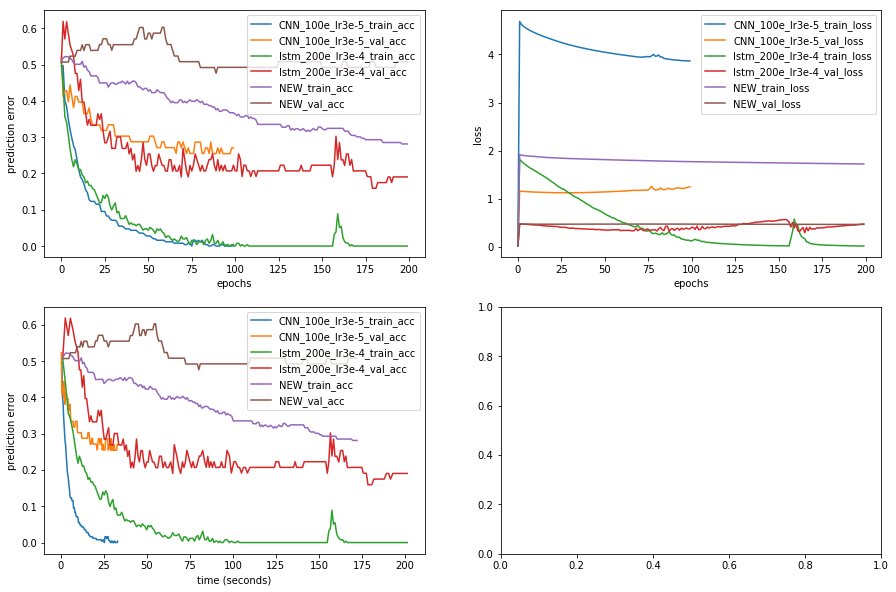

In [117]:
# potential_models: ["lstm_1", "lstm_1_300epochs", "conv_net1", "lstm_1_100e_1000hrz", "linear_2000e_100hrz", 
# "ligsig_2000e_100hrz", "linear_2000e_100hrz"]

# with proper dict: ["ligsmax_200e_100hrz", "ligsig_200e_100hrz", "linear_2000e_100hrz", "lstm_200e_100hrz",
# "lstm_0.4drop_old", "lstm_0.4drop_old", "lstm_0.4drop_200e_100hrz", "lstm_0.6drop_200e_100hrz", 
#"lstm2_0.4drop_200e_100hrz", "lstm2_0.2drop_200e_100hrz"]

#1 final = ["linear_1500e_lr3e-5", logistic_1500e_lr1e-4, "FFNN_34e_lr1e-4", "CNN_100e_lr3e-5", "lstm_200e_lr3e-4"]

PL.plot_model_training(history=history, models=["CNN_100e_lr3e-5", "lstm_200e_lr3e-4"], plt_name="lstm_vs_cnn") # "lstm_200e_100hrz"


### Saving model with training data
Just uncomment and run to save recently trained model

In [119]:
#"logistic_1500e_lr1e-4"
HL.pickle_model(trained_model, history, parameters, "lstm_sgd_200e")

### Testing models

In [120]:

HL.test_models(train_data, val_data, test_data, 
               ["lstm_200e_100hrz", "lstm_0.1drop_old",
 "lstm_0.4drop_old", "lstm_0.4drop_200e_100hrz", "lstm_0.6drop_200e_100hrz", "lstm2_0.4drop_200e_100hrz",
 "lstm2_0.2drop_200e_100hrz"])
 

#PART 1:
HL.test_models(train_data, val_data, test_data,
["linear_1500e_lr3e-5", "logistic_1500e_lr1e-4", "FFNN_34e_lr1e-4", "CNN_100e_lr3e-5", "lstm_200e_lr3e-4"])

#PART 2:
HL.test_models(train_data, val_data, test_data, 
["lstm_200e_lr3e-4", "lstm_50h_04d_200e_lr3e-4", "lstm_300h_04d_200e_lr3e-4", "lstm2_111h_04d_200e_lr3e-4",
 "lstm_111h_05d_200e_lr3e-4"])

#PART 3
HL.test_models(train_data, val_data, test_data,
["lstm_200e_lr3e-4", "lstm_sgd_200e"])




Calculating prediction error on an ensemble of trained models

| Model name:                | Train error:               | Validation error:          | Test error                 
| lstm_200e_100hrz           | 0.0                        | 0.17590725806451613        | 0.265625                   
| lstm_0.1drop_old           | 0.05118534482758621        | 0.23840725806451613        | 0.3203125                  
| lstm_0.4drop_old           | 0.01953125                 | 0.1592741935483871         | 0.1796875                  
| lstm_0.4drop_200e_100hrz   | 0.0                        | 0.1436491935483871         | 0.1875                     
| lstm_0.6drop_200e_100hrz   | 0.0390625                  | 0.15977822580645162        | 0.328125                   
| lstm2_0.4drop_200e_100hrz  | 0.01953125                 | 0.17590725806451613        | 0.1875                     
| lstm2_0.2drop_200e_100hrz  | 0.0                        | 0.16028225806451613        | 0.25                       


## If more time would have done:
- spent more time on understanding the underlying eeg-data
- I read about how to make spacial features based on where the electodes are placed on the head.
- data augmentation
- tested gru
- tested temporal convnet with dilution
- earlystopping